<a href="https://colab.research.google.com/github/Ni-cole17/intro-dados-pd/blob/main/projeto_dados_porto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Dados: Análise de Ocorrências Aeronáuticas na Aviação Civil Brasileira ✈ 🐦

## Objetivo
O objetivo deste projeto é permitir de forma simples, juntar o que aprendemos,  para identificar padrões nas ocorrências aeronáuticas no Brasil. Para isso, serão aplicadas os principais conceitos de engenharia de dados, técnicas de manipulação e visualização de dados para responder perguntas.

## Requisitos
(CENÁRIO FICTÍCIO)

A Embraer está com um projeto junto ao porto digital. O projeto consiste na criação de uma solução de dados para analisar o conjunto de dados do Centro de Investigação e Prevenção de Acidentes Aeronáuticos (CENIPA), que contém registros detalhados de incidentes e acidentes na aviação civil brasileira com aves. O cliente deseja responder a perguntas para entender melhor como está o cenário histórico de acidentes e incidentes com aves no Brasil:

 - Quais são os principais tipos de reportes e como eles se comportam ao longo dos anos?
 - Como as ocorrências estão distribuídas geograficamente?
 - Há padrões sazonais que indicam aumento no número de incidentes em determinados períodos do dia? (Considerar horário de Brasília)
 - Existe alguma relação do tipo de passáro com o tipo de ocorrência?

Para isso deve ser montado um ambiente que tenha:
 - Local para os dados serem armazenados em seu formato original
 - Local para os dados serem armazenados após tratados
 - Disponibilização dos dados para consumo
 - Criação das visualizações

A base fornecida pode ser consultada no seguinte endereço:

Reportes_2011_2021: https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira: Reportes Risco de Fauna 2011 a 2021
|

Reportes_especies_2011_2021: https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira: Espécies do Risco de Fauna de 2011 a 2021.

## Coleta e definição das bases de dados

In [ ]:
## ESSA ETAPA PODE SER REALIZADA VIA SCRIPT OU COM ALGUMA FERRAMENTA COMO O EXCEL.

Outras bases que vamos utilizar para enriquecer os dados:

AerodromosPrivados: https://www.anac.gov.br/acesso-a-informacao/dados-abertos/areas-de-atuacao/aerodromos/lista-de-aerodromos-privados-v2

AerodromosPublicos: https://www.anac.gov.br/acesso-a-informacao/dados-abertos/areas-de-atuacao/aerodromos/lista-de-aerodromos-publicos-v2

utc: Desenvolvido Manualmente

## Preparação do ambiente

### Instalação Bibliotecas

In [3]:
!pip install unidecode
!pip install pyspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [4]:
from unidecode import unidecode
import requests
import pandas as pd
from io import StringIO
import os

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, StringType,FloatType,IntegerType,StructType, DateType, TimestampType,DoubleType

In [5]:
## Definição do spark com configurações básicas
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Iniciando com Spark') \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

## Dica: Geralmente são definidas muito mais variáveis ao iniciar uma sessão do spark, principalmente quando se trabalha com BigData, como:
## Número de executores e drives, espaços na memória, entre outros...
## Essas definições são importantes pois otimizam o funcionamento do processamento de dados, reduzindo tempo e custo do projeto.

### Criação da arquitetura de armazenamento

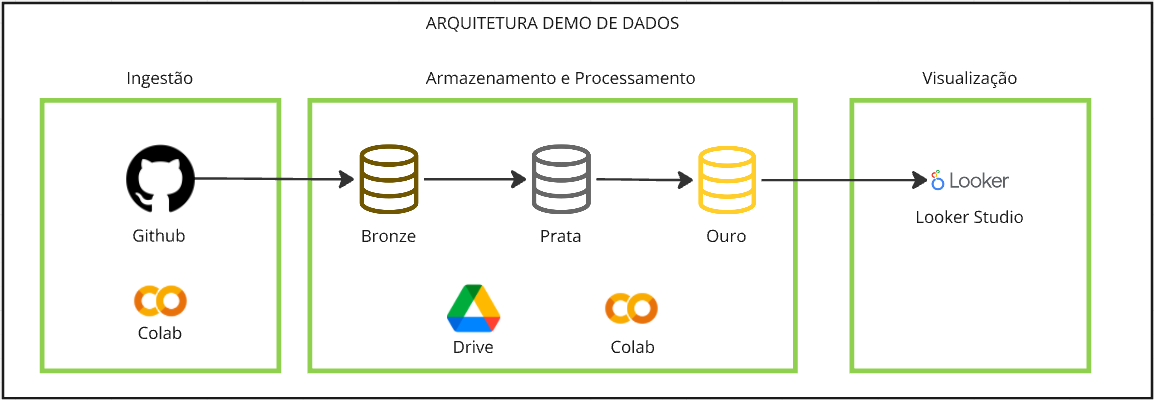

1º Desafio: Melhorem a arquitetura de dados utilizando alguma cloud.

Definam:

    - Qual ferramenta vocês vão utilizar para armazenamento;

    - Qual ferramenta vão utilizar para realizar a ingestão de dados, assim como a origem desses dados;

    - Qual/Quais ferramentas vão utilizar para o processamento dos dados e automatização das pipelines;

    - Qual ferramenta vão utilizar para a visualização de dados.

Dicas: Ver sempre a conectividade entre as ferramentas que vocês vão usar e a viabilidade do projeto que vocês estão fazendo. (Evitar serviços muito caros e que não vão ser necessários pela volumetria dos dados) e justifiquem tudo que estiverem utilizando.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Nessa etapa vamos criar as pastas correspondentes a cada camada de dados
## Onde terá os dados mais brutos até os dados que serão utilizados para as visualizações
## Para isso vamos criar as pastas com o comando MKDIR do linux
!rm -rf sample_data
!mkdir -p '/content/drive/MyDrive/projeto_dados/bronze'
!mkdir -p '/content/drive/MyDrive/projeto_dados/prata'
!mkdir -p '/content/drive/MyDrive/projeto_dados/ouro'
## Essa etapa corresponde à etapa de criação do serviço de armazenamento de dados na nuvem, assim como dos espaços onde os dados ficarão armazenados
### DICA: Pode ser utilizado ferramentas como o Terraform para definir a arquitetura em cloud (AVANÇADO)


## Ingestão dos dados

In [25]:
def get_files_to_raw(url: str, sub_folder: str, path_padrao: str='/content/drive/MyDrive/projeto_dados/bronze',token_folder: str = '/content/drive/MyDrive/projeto_dados/TOKENS/token.txt'):
    """
    Baixa um arquivo de um repositório GitHub e o salva localmente.

    Parâmetros:
    url (str): URL da API do GitHub para o arquivo desejado.
        Exemplo: "https://api.github.com/repos/usuario/repo/contents/caminho/para/o/arquivo.csv"
    sub_folder (str): Subpasta onde o arquivo será salvo. A pasta será composta pelo path padrão definido e o nome do arquivo.

    Retorno:
    Nenhum. A função salva o arquivo diretamente no diretório local.

    Descrição:
    - A função faz uma requisição GET à API do GitHub para obter o arquivo especificado na URL.
    - A requisição inclui um token de autenticação para o GitHub.
    - Caso a requisição seja bem-sucedida, a função obtém a URL para download direto do arquivo.
    - O arquivo é então baixado e salvo localmente na pasta padrão, com o nome extraído da URL.
    - Em caso de erro durante o processo, a função imprime uma mensagem de erro.

    Exemplo de uso:
    >>> url = "https://api.github.com/repos/usuario/repo/contents/caminho/para/o/arquivo.csv"
    >>> sub_folder = "bronze"
    >>> get_files_to_raw(url, sub_folder)
    """

    ## Definindo constantes
    with open(token_folder, 'r') as f:
        TOKEN = f.read().strip()
    headers = {"Authorization": f"token {TOKEN}"} # Autenticação
    file_path = url.split('/')[-1].lower() # Padronizando o nome dos arquivos

    # Requisição à API
    response = requests.get(url, headers=headers)

    # Cria o diretório na bronze se caso não existir
    if not os.path.exists(f"{path_padrao}/{sub_folder}"):
        os.makedirs(f"{path_padrao}/{sub_folder}")

    # Se o resultado for 200, faz o download do arquivo
    if response.status_code == 200:
        file_data = response.json()
        download_url = file_data["download_url"]  # Obtém a URL bruta do arquivo
        response_csv = requests.get(download_url, headers=headers) # Baixa o conteúdo do arquivo

        if response_csv.status_code == 200:
            # Salva o arquivo CSV no caminho
            with open(f"{path_padrao}/{sub_folder}/{file_path}", "w", encoding="utf-8") as file:
                file.write(response_csv.text)
            print("Arquivo salvo com sucesso!")
        else:
            print(f"Erro ao baixar o CSV: {response_csv.status_code}")
    else:
        print(f"Erro ao acessar o arquivo: {response.status_code} - {response.text}")

In [26]:
OWNER = "Ni-cole17"          # Nome do dono do repositório
REPO = "intro-dados-pd"      # Nome do repositório

dict_data = {
             'reportes_2011_2021':{'path':'data/reportes_2011_2021.csv','sub_folder':'reportes'},
             'reportes_especies_2011_2021':{'path':'data/reportes_especies_2011_2021.csv','sub_folder':'especies'},
             'AerodromosPrivados':{'path':'data/AerodromosPrivados.csv','sub_folder':'aerodromos'},
             'AerodromosPublicos':{'path':'data/AerodromosPublicos.csv','sub_folder':'aerodromos'},
             'utc':{'path':'data/utc.csv','sub_folder':'utc'}
             }

for chave, valor in dict_data.items():
  url = f"https://api.github.com/repos/{OWNER}/{REPO}/contents/{valor['path']}"
  get_files_to_raw(url,sub_folder=valor['sub_folder'])

Arquivo salvo com sucesso!
Arquivo salvo com sucesso!
Arquivo salvo com sucesso!
Arquivo salvo com sucesso!
Arquivo salvo com sucesso!


## Extração, Processamento e Carregamento

In [ ]:
def create_file_path_dictionary(root_dir: str) -> str:
    """
    Cria um dicionário com os caminhos dos arquivos.

    Args:
    root_dir: O diretório raiz para procurar os arquivos.

    Returns:
    Um dicionário onde as chaves são os nomes dos arquivos e os valores são seus caminhos completos.
    """
    file_paths = {}
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            file_paths[filename.replace(".csv","")] = os.path.join(dirpath, filename)
    return file_paths

file_dict = create_file_path_dictionary("/content/drive/MyDrive/projeto_dados/bronze")
file_dict

{'reportes_2011_2021': '/content/drive/MyDrive/projeto_dados/bronze/reportes/reportes_2011_2021.csv',
 'reportes_especies_2011_2021': '/content/drive/MyDrive/projeto_dados/bronze/especies/reportes_especies_2011_2021.csv',
 'aerodromosprivados': '/content/drive/MyDrive/projeto_dados/bronze/aerodromos/aerodromosprivados.csv',
 'aerodromospublicos': '/content/drive/MyDrive/projeto_dados/bronze/aerodromos/aerodromospublicos.csv',
 'utc': '/content/drive/MyDrive/projeto_dados/bronze/utc/utc.csv'}

### Camada Prata

In [ ]:
class Raw_to_refined():
    """
    Classe responsável pelo processamento de dados da camada Bronze para a camada Prata (Raw to Refined).

    Métodos:
        - clean_columns_name(df): Padroniza os nomes das colunas, removendo acentos e substituindo espaços por "_".
        - clean_data(df): Aplica tratamentos gerais aos dados (pode ser customizado).
        - data_types(df, schema): Converte os tipos das colunas com base no schema fornecido.
        - verify_dup(df, id_column): Verifica a existência de registros duplicados com base em uma coluna identificadora.
        - create_view(df, tempview_name): Cria uma temporary view do DataFrame para consultas SQL.
    """

    def __init__(self):
        """Inicializa a classe Raw_to_refined."""
        pass

    def clean_columns_name(self, df: DataFrame) -> DataFrame:
        """
        Padroniza os nomes das colunas:
            - Remove acentos
            - Substitui espaços por "_"
            - Converte para minúsculas

        Parâmetros:
            df (DataFrame): DataFrame do PySpark com os dados a serem processados.

        Retorno:
            DataFrame: DataFrame com colunas renomeadas.
        """
        for colunas in df.columns:
            df = df.withColumnRenamed(colunas, unidecode(colunas.replace(' ', '_')).lower())
        return df

    def clean_data(self, df: DataFrame) -> DataFrame:
        """
        Aplica tratamentos gerais nos dados.

        Parâmetros:
            df (DataFrame): DataFrame do PySpark com os dados brutos.

        Retorno:
            DataFrame: DataFrame processado.
        """
        return df  # Pode ser expandido conforme necessidade

    def data_types(self, df: DataFrame, schema: StructType) -> DataFrame:
        """
        Converte os tipos das colunas do DataFrame com base no schema fornecido.

        Parâmetros:
            df (DataFrame): DataFrame do PySpark com os dados.
            schema (StructType): Schema contendo os tipos corretos para cada coluna.

        Retorno:
            DataFrame: DataFrame com as colunas convertidas para os tipos especificados no schema.
        """
        for field in schema.fields:
            df = df.withColumn(field.name, F.col(field.name).cast(field.dataType))
        return df

    def verify_dup(self, df: DataFrame, id_column: str) -> None:
        """
        Verifica se há registros duplicados com base em uma coluna identificadora.

        Parâmetros:
            df (DataFrame): DataFrame do PySpark com os dados.
            id_column (str): Nome da coluna que será usada para verificar duplicatas.

        Retorno:
            None: Apenas imprime se há ou não dados duplicados.
        """
        if df.count() != df.select(id_column).distinct().count():
            print("Tem dados duplicados")
        else:
            print("Não tem dados duplicados")

    def create_view(self, df: DataFrame, tempview_name: str) -> None:
        """
        Cria uma temporary view do DataFrame para permitir consultas SQL.

        Parâmetros:
            df (DataFrame): DataFrame do PySpark que será transformado em view temporária.
            tempview_name (str): Nome da temporary view.

        Retorno:
            None: Apenas cria a view temporária no Spark.
        """
        df.createOrReplaceTempView(tempview_name)



#### Especies

In [ ]:
## Lendo a tabela com o spark read csv
especies = spark.read.csv(file_dict['reportes_especies_2011_2021'],sep=',',header=True)

In [ ]:
especies.show(truncate=False)

+--------------+------------+--------------------+--------+-----------+-------+-------+--------+--------+---------+----------------------------------------------------+-----------------------------------------------------+---------+
|cod_va_especie|cod_cenipa15|cod_cenipa15_especie|coletada|fotografada|enviada|amostra|avistada|atingida|tamanho.x|nome_pt                                             |nome_en                                              |tamanho.y|
+--------------+------------+--------------------+--------+-----------+-------+-------+--------+--------+---------+----------------------------------------------------+-----------------------------------------------------+---------+
|1             |24513       |311                 |NA      |NA         |NA     |NA     |11-50   |NA      |MG       |Urubu-de-cabeça-preta/corvo/apitã (Coragyps atratus)|Black Vulture (Coragyps atratus)                     |MG       |
|3             |25121       |447                 |NA      |NA       

In [ ]:
class raw_to_refined_especies(Raw_to_refined):
    def __init__(self):
        pass

    def clean_data(self,df):
        df = df.withColumn("nome_pt",F.regexp_replace(F.split(F.col("nome_pt"), "/").getItem(0), r"\s*\(.*?\)", ""))
        df = df.withColumn(
            "nome_pt",
            F.when(
                F.col("nome_pt").contains("Outros"),
                F.regexp_extract(F.col("nome_pt"), r"Outros", 0)
            ).when(
                F.col("nome_pt").contains("Não identificada"),
                F.regexp_extract(F.col("nome_pt"), r"Não identificada", 0)
            ).otherwise(F.col("nome_pt"))
        )

        df = df.withColumn("nome_pt",F.regexp_replace(F.col("nome_pt"), r"^xx\s+", ""))
        return df

In [ ]:
transform_especies = raw_to_refined_especies()

In [ ]:
df = transform_especies.clean_columns_name(especies)
df = transform_especies.clean_data(df)

In [ ]:
df.printSchema()

root
 |-- cod_va_especie: string (nullable = true)
 |-- cod_cenipa15: string (nullable = true)
 |-- cod_cenipa15_especie: string (nullable = true)
 |-- coletada: string (nullable = true)
 |-- fotografada: string (nullable = true)
 |-- enviada: string (nullable = true)
 |-- amostra: string (nullable = true)
 |-- avistada: string (nullable = true)
 |-- atingida: string (nullable = true)
 |-- tamanho.x: string (nullable = true)
 |-- nome_pt: string (nullable = true)
 |-- nome_en: string (nullable = true)
 |-- tamanho.y: string (nullable = true)



In [ ]:
df.show(truncate=False)

+--------------+------------+--------------------+--------+-----------+-------+-------+--------+--------+---------+----------------------+-----------------------------------------------------+---------+
|cod_va_especie|cod_cenipa15|cod_cenipa15_especie|coletada|fotografada|enviada|amostra|avistada|atingida|tamanho.x|nome_pt               |nome_en                                              |tamanho.y|
+--------------+------------+--------------------+--------+-----------+-------+-------+--------+--------+---------+----------------------+-----------------------------------------------------+---------+
|1             |24513       |311                 |NA      |NA         |NA     |NA     |11-50   |NA      |MG       |Urubu-de-cabeça-preta |Black Vulture (Coragyps atratus)                     |MG       |
|3             |25121       |447                 |NA      |NA         |NA     |NA     |11-50   |NA      |M        |Garça-vaqueira        |Cattle Egret (Bubulcus ibis)                      

In [ ]:
transform_especies.verify_dup(df, 'cod_va_especie')

Não tem dados duplicados


In [ ]:
df = df.select("cod_va_especie","cod_cenipa15","nome_pt")

In [ ]:
df.write.mode('overwrite').format('parquet').save('/content/drive/MyDrive/projeto_dados/prata/especies')

#### Reportes

In [ ]:
class raw_to_refined_reports(Raw_to_refined):
    def __init__(self):
        pass

    def clean_data(self,df):
        df = df.withColumn("hora_local", F.date_format("hora_local", "HH:mm:ss"))
        df = df.withColumn("data", F.to_date(df["data"], "dd/MM/yyyy"))
        df = df.withColumn("icao", F.upper(F.regexp_replace("icao", r"[^A-Za-z0-9].*", "")))

        df = df.select("codigo_reporte","classificacao_ocorrencia","tipo_reporte","data","hora_local","icao","fase_voo","efeito_no_voo")
        return df

In [ ]:
reportes = spark.read.csv(file_dict['reportes_2011_2021'],sep=';',header=True)

In [ ]:
transform = raw_to_refined_reports()

In [ ]:
reportes.show(truncate=False)

+--------------+------------------------+-------------+-------------+----------+------------------------+------------------------+---------------------------------+------------+------------------------+------------------------+----------+-----------+----+-----+----+----------------------------+-----------------+------+----------+----------------+-------------------------------+---------------+----------------------------+------------+---------------+---------------+---------------+
|codigo_reporte|classificacao_ocorrencia|tipo_reporte |matricula_anv|data      |operador                |fabricante_anv          |modelo_anv                       |aviaco_tipo |fabricante_motor        |modelo_motor            |hora_local|periodo_dia|icao|pista|lado|Area_Seguranca_Aeroportuaria|coordenada_radial|altura|velocidade|fase_voo        |Efeito_no_voo                  |condicao_do_ceu|visibilidade                |precipitacao|Danos_Prejuizos|Aeronave_Indisp|Piloto_alertado|
+--------------+----------

In [ ]:
reportes.printSchema()

root
 |-- codigo_reporte: string (nullable = true)
 |-- classificacao_ocorrencia: string (nullable = true)
 |-- tipo_reporte: string (nullable = true)
 |-- matricula_anv: string (nullable = true)
 |-- data: string (nullable = true)
 |-- operador: string (nullable = true)
 |-- fabricante_anv: string (nullable = true)
 |-- modelo_anv: string (nullable = true)
 |-- aviaco_tipo: string (nullable = true)
 |-- fabricante_motor: string (nullable = true)
 |-- modelo_motor: string (nullable = true)
 |-- hora_local: string (nullable = true)
 |-- periodo_dia: string (nullable = true)
 |-- icao: string (nullable = true)
 |-- pista: string (nullable = true)
 |-- lado: string (nullable = true)
 |-- Area_Seguranca_Aeroportuaria: string (nullable = true)
 |-- coordenada_radial: string (nullable = true)
 |-- altura: string (nullable = true)
 |-- velocidade: string (nullable = true)
 |-- fase_voo: string (nullable = true)
 |-- Efeito_no_voo: string (nullable = true)
 |-- condicao_do_ceu: string (nullabl

In [ ]:
schema_reportes = StructType([
    StructField("codigo_reporte", StringType(), True),
    StructField("classificacao_ocorrencia", StringType(), True),
    StructField("tipo_reporte", StringType(), True),
    StructField("data", StringType(), True),
    StructField("hora_local", StringType(), True),
    StructField("fase_voo", StringType(), True),
    StructField("efeito_no_voo", StringType(), True),
])

reportes = transform.data_types(reportes, schema_reportes)
reportes = transform.clean_data(reportes)

In [ ]:
reportes.show(truncate=False)

+--------------+------------------------+-------------+----------+----------+----+----------------+-------------------------------+
|codigo_reporte|classificacao_ocorrencia|tipo_reporte |data      |hora_local|icao|fase_voo        |efeito_no_voo                  |
+--------------+------------------------+-------------+----------+----------+----+----------------+-------------------------------+
|197           |Incidente               |colisão      |2011-02-27|16:00:00  |SBRP|decolagem       |Decolagem abortada             |
|198           |Incidente               |colisão      |2011-01-24|18:40:00  |SBCO|decolagem       |Decolagem abortada             |
|199           |Incidente               |colisão      |2011-01-24|19:25:00  |SBCO|pouso           |Nenhum                         |
|201           |Incidente               |colisão      |2011-04-08|14:29:00  |SBSL|aproximação     |Nenhum                         |
|205           |Incidente               |colisão      |2011-02-11|11:02:00  

In [ ]:
reportes.printSchema()

root
 |-- codigo_reporte: string (nullable = true)
 |-- classificacao_ocorrencia: string (nullable = true)
 |-- tipo_reporte: string (nullable = true)
 |-- data: date (nullable = true)
 |-- hora_local: string (nullable = true)
 |-- icao: string (nullable = true)
 |-- fase_voo: string (nullable = true)
 |-- efeito_no_voo: string (nullable = true)



In [ ]:
reportes.write.mode('overwrite').format('parquet').save('/content/drive/MyDrive/projeto_dados/prata/reportes')

In [ ]:
import os

def tamanho_pasta(caminho_pasta):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(caminho_pasta):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size

caminho = "/content/drive/MyDrive/projeto_dados/bronze/reportes"
tamanho_bytes_bronze = tamanho_pasta(caminho)
print(f"Tamanho da pasta bronze: {tamanho_bytes_bronze / (1024 * 1024):.2f} MB")  # Converte para MB

caminho = "/content/drive/MyDrive/projeto_dados/prata/reportes"
tamanho_bytes = tamanho_pasta(caminho)
print(f"Tamanho da pasta prata: {tamanho_bytes / (1024 * 1024):.2f} MB")  # Converte para MB

print(f"A pasta prata corresponde a {(tamanho_bytes/tamanho_bytes_bronze)*100:.3}% da pasta bronze")

Tamanho da pasta bronze: 17.52 MB
Tamanho da pasta prata: 0.72 MB
A pasta prata corresponde a 4.13% da pasta bronze


#### UTC

In [ ]:
class raw_to_refined_utc(Raw_to_refined):
    def __init__(self):
        pass

    def clean_data(self,df):
        df = df.withColumn("utc", F.regexp_extract("utc", r"([+-]?\d+)", 1).cast("integer"))
        df = df.withColumn("uf", F.lower(df["uf"]))
        df = df.withColumn("estado", F.lower(F.translate(df["estado"], "áéíóúãõâêîôûçÁÉÍÓÚÃÕÂÊÎÔÛÇ", "aeiouaoaeioucAEIOUAOAEIOUC")))

        df = df.select("uf","estado","utc")

        return df

In [ ]:
utc = spark.read.csv(file_dict['utc'],sep=';',header=True)

In [ ]:
utc.printSchema()

root
 |-- uf: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- utc: string (nullable = true)



In [ ]:
transform = raw_to_refined_utc()

In [ ]:
utc = transform.clean_data(utc)

In [ ]:
utc.show(truncate=False)

+---+-------------------+---+
|uf |estado             |utc|
+---+-------------------+---+
|ac |acre               |-5 |
|ap |amapa              |-3 |
|al |alagoas            |-3 |
|am |amazonas           |-4 |
|ba |bahia              |-3 |
|ce |ceara              |-3 |
|es |espirito santo     |-3 |
|go |goias              |-3 |
|ma |maranhao           |-3 |
|mt |mato grosso        |-4 |
|ms |mato grosso do sul |-4 |
|mg |minas gerais       |-3 |
|pa |para               |-3 |
|pb |paraiba            |-3 |
|pr |parana             |-3 |
|pe |pernambuco         |-3 |
|pi |piaui              |-3 |
|rj |rio de janeiro     |-3 |
|rn |rio grande do norte|-3 |
|rs |rio grande do sul  |-3 |
+---+-------------------+---+
only showing top 20 rows



In [ ]:
transform.create_view(utc,'utc')

#### Aerodromos

In [ ]:
class raw_to_refined_aerodromo(Raw_to_refined):
    def __init__(self):
        pass

    def clean_data(self,df):
        df = df.withColumn('nome',F.lower(F.col('nome')))
        df = df.withColumn('municipio',F.lower(F.col('municipio')))
        df = df.withColumn("uf", F.lower(F.translate(df["uf"], "áéíóúãõâêîôûçÁÉÍÓÚÃÕÂÊÎÔÛÇ", "aeiouaoaeioucAEIOUAOAEIOUC")))
        df = df.withColumn("codigo_oaci", F.upper(F.col('codigo_oaci')))


        df = df.withColumn('latgeopoint',F.regexp_replace(F.col('latgeopoint'), ',', '.'))
        df = df.withColumn('longeopoint',F.regexp_replace(F.col('latgeopoint'), ',', '.'))

        return df

##### Aerodromo privado

In [ ]:
aero_priv = spark.read.csv(file_dict['aerodromosprivados'],sep=';',header=True)

In [ ]:
transform = raw_to_refined_aerodromo()

In [ ]:
df = transform.clean_columns_name(aero_priv)
df = transform.clean_data(df)

In [ ]:
df.printSchema()

root
 |-- codigo_oaci: string (nullable = true)
 |-- ciad: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- operacao_diurna: string (nullable = true)
 |-- operacao_noturna: string (nullable = true)
 |-- designacao_1: string (nullable = true)
 |-- comprimento_1: string (nullable = true)
 |-- largura_1: string (nullable = true)
 |-- resistencia_1: string (nullable = true)
 |-- superficie_1: string (nullable = true)
 |-- designacao_2: string (nullable = true)
 |-- comprimento_2: string (nullable = true)
 |-- largura_2: string (nullable = true)
 |-- resistencia_2: string (nullable = true)
 |-- superficie_2: string (nullable = true)
 |-- portaria_de_registro: string (nullable = true)
 |-- link_portaria: string (nullable = true)
 |-- latgeopoint: string (nullable = true)
 |-- longeo

In [ ]:
schema_aero_priv = StructType([
    StructField("codigo_oaci", StringType(), True),
    StructField("ciad", StringType(), True),
    StructField("nome", StringType(), True),
    StructField("municipio", StringType(), True),
    StructField("uf", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("altitude", StringType(), True),
    StructField("operacao_diurna", StringType(), True),
    StructField("operacao_noturna", StringType(), True),
    StructField("designacao_1", StringType(), True),
    StructField("comprimento_1", FloatType(), True),
    StructField("largura_1", FloatType(), True),
    StructField("resistencia_1", StringType(), True),
    StructField("superficie_1", StringType(), True),
    StructField("designacao_2", StringType(), True),
    StructField("comprimento_2", FloatType(), True),
    StructField("largura_2", FloatType(), True),
    StructField("resistencia_2", StringType(), True),
    StructField("superficie_2", StringType(), True),
    StructField("portaria_de_registro", StringType(), True),
    StructField("link_portaria", StringType(), True),
    StructField("latgeopoint", StringType(), True),
    StructField("longeopoint", StringType(), True)
])

df = transform.data_types(df, schema_aero_priv)


In [ ]:
df.printSchema()

root
 |-- codigo_oaci: string (nullable = true)
 |-- ciad: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- operacao_diurna: string (nullable = true)
 |-- operacao_noturna: string (nullable = true)
 |-- designacao_1: string (nullable = true)
 |-- comprimento_1: float (nullable = true)
 |-- largura_1: float (nullable = true)
 |-- resistencia_1: string (nullable = true)
 |-- superficie_1: string (nullable = true)
 |-- designacao_2: string (nullable = true)
 |-- comprimento_2: float (nullable = true)
 |-- largura_2: float (nullable = true)
 |-- resistencia_2: string (nullable = true)
 |-- superficie_2: string (nullable = true)
 |-- portaria_de_registro: string (nullable = true)
 |-- link_portaria: string (nullable = true)
 |-- latgeopoint: string (nullable = true)
 |-- longeopoin

In [ ]:
df.show(truncate=False)

+-----------+------+---------------------------------+----------------------+---+-----------------+---------------+--------+---------------+----------------+------------+-------------+---------+--------------------+------------+------------+-------------+---------+--------------------+------------+--------------------+-------------------------------------------------------+-----------+-----------+
|codigo_oaci|ciad  |nome                             |municipio             |uf |longitude        |latitude       |altitude|operacao_diurna|operacao_noturna|designacao_1|comprimento_1|largura_1|resistencia_1       |superficie_1|designacao_2|comprimento_2|largura_2|resistencia_2       |superficie_2|portaria_de_registro|link_portaria                                          |latgeopoint|longeopoint|
+-----------+------+---------------------------------+----------------------+---+-----------------+---------------+--------+---------------+----------------+------------+-------------+---------+----

In [ ]:
transform.verify_dup(df, 'ciad')

Não tem dados duplicados


In [ ]:
transform.create_view(df,'aero_priv')

##### Aero Publico

In [ ]:
aero_pub = spark.read.csv(file_dict['aerodromospublicos'],sep=';',header=True)

In [ ]:
df = transform.clean_columns_name(aero_pub)
df = transform.clean_data(df)

In [ ]:
df.printSchema()

root
 |-- codigo_oaci: string (nullable = true)
 |-- ciad: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- municipio_servido: string (nullable = true)
 |-- uf_servido: string (nullable = true)
 |-- latgeopoint: string (nullable = true)
 |-- longeopoint: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- operacao_diurna: string (nullable = true)
 |-- operacao_noturna: string (nullable = true)
 |-- designacao_1: string (nullable = true)
 |-- comprimento_1: string (nullable = true)
 |-- largura_1: string (nullable = true)
 |-- resistencia_1: string (nullable = true)
 |-- superficie_1: string (nullable = true)
 |-- designacao_2: string (nullable = true)
 |-- comprimento_2: string (nullable = true)
 |-- largura_2: string (nullable = true)
 |-- resistencia_2: string (nullable = true)
 |-- superficie_2:

In [ ]:
schema_aero_pub = StructType([
    StructField("codigo_oaci", StringType(), True),
    StructField("ciad", StringType(), True),
    StructField("nome", StringType(), True),
    StructField("municipio", StringType(), True),
    StructField("uf", StringType(), True),
    StructField("municipio_servido", StringType(), True),
    StructField("uf_servido", StringType(), True),
    StructField("latgeopoint", StringType(), True),
    StructField("longeopoint", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("altitude", FloatType(), True),
    StructField("operacao_diurna", StringType(), True),
    StructField("operacao_noturna", StringType(), True),
    StructField("designacao_1", StringType(), True),
    StructField("comprimento_1", FloatType(), True),
    StructField("largura_1", FloatType(), True),
    StructField("resistencia_1", StringType(), True),
    StructField("superficie_1", StringType(), True),
    StructField("designacao_2", StringType(), True),
    StructField("comprimento_2", FloatType(), True),
    StructField("largura_2", FloatType(), True),
    StructField("resistencia_2", StringType(), True),
    StructField("superficie_2", StringType(), True),
    StructField("situacao", StringType(), True),
    StructField("validade_do_registro", StringType(), True),
    StructField("portaria_de_registro", StringType(), True),
    StructField("link_portaria", StringType(), True)
])

df = transform.data_types(df, schema_aero_pub)

In [ ]:
df.show(truncate=False)

+-----------+------+------------------------------------+-------------+------------------+-----------------+------------------+-----------+-----------+-------------+--------------+--------+----------------------+----------------------+------------+-------------+---------+--------------------+------------+------------+-------------+---------+-------------+------------+-----------+--------------------+--------------------+-------------------------------------------------------+
|codigo_oaci|ciad  |nome                                |municipio    |uf                |municipio_servido|uf_servido        |latgeopoint|longeopoint|latitude     |longitude     |altitude|operacao_diurna       |operacao_noturna      |designacao_1|comprimento_1|largura_1|resistencia_1       |superficie_1|designacao_2|comprimento_2|largura_2|resistencia_2|superficie_2|situacao   |validade_do_registro|portaria_de_registro|link_portaria                                          |
+-----------+------+------------------

In [ ]:
transform.verify_dup(df, 'ciad')

Não tem dados duplicados


In [ ]:
transform.create_view(df,'aero_pub')

In [ ]:
df_join = spark.sql("""
                        SELECT DISTINCT
                        codigo_oaci,
                        ciad,
                        nome,
                        municipio,
                        utc.estado as uf,
                        utc.utc as utc,
                        'privado' as origem
                    FROM
                        aero_priv
                    LEFT JOIN utc
                    ON aero_priv.uf = utc.uf
                    UNION ALL
                    SELECT DISTINCT
                        codigo_oaci,
                        ciad,
                        nome,
                        municipio,
                        aero_pub.uf,
                        utc.utc,
                        'publico' as origem
                    FROM
                        aero_pub
                    LEFT JOIN utc
                    ON aero_pub.uf = utc.estado

""")

In [ ]:
df_join.where("utc is null").show(truncate=False)

+-----------+------+-------+---------+----+----+-------+
|codigo_oaci|ciad  |nome   |municipio|uf  |utc |origem |
+-----------+------+-------+---------+----+----+-------+
|SDRS       |RJ0007|resende|NULL     |NULL|NULL|publico|
+-----------+------+-------+---------+----+----+-------+



In [ ]:
transform.verify_dup(df_join, 'ciad')

Não tem dados duplicados


In [ ]:
df_join.write.mode('overwrite').format('parquet').partitionBy('origem').save('/content/drive/MyDrive/projeto_dados/prata/aerodromos')

### Camada Ouro

In [ ]:
#Quais são os principais tipos de reportes e como eles se comportam ao longo dos anos?
#Como as ocorrências estão distribuídas geograficamente?
#Há padrões sazonais que indicam aumento no número de incidentes em determinados períodos?
#Existe alguma relação do tipo de passáro com o tipo de ocorrência?

In [ ]:
reportes = spark.read.parquet("/content/drive/MyDrive/projeto_dados/prata/reportes")
aerodromos = spark.read.parquet("/content/drive/MyDrive/projeto_dados/prata/aerodromos")
especies = spark.read.parquet("/content/drive/MyDrive/projeto_dados/prata/especies")

In [ ]:
reportes.createOrReplaceTempView("reportes")
aerodromos.createOrReplaceTempView("aerodromos")
especies.createOrReplaceTempView("especies")

In [ ]:
aerodromos.show(5,truncate=False)

+-----------+------+-------------------+----------+------------------+---+-------+
|codigo_oaci|ciad  |nome               |municipio |uf                |utc|origem |
+-----------+------+-------------------+----------+------------------+---+-------+
|SJFO       |GO0071|fazenda sorriso    |mossâmedes|goias             |-3 |privado|
|SJKV       |RR0042|cumanã 1           |pacaraima |roraima           |-4 |privado|
|SD93       |MS0548|fazenda são vicente|ponta porã|mato grosso do sul|-4 |privado|
|SWLX       |MT0365|fazenda analice    |jauru     |mato grosso       |-4 |privado|
|SWAG       |TO0041|agrícola rio galhão|mateiros  |tocantins         |-3 |privado|
+-----------+------+-------------------+----------+------------------+---+-------+
only showing top 5 rows



In [ ]:
big_table = spark.sql("""
    WITH big_table as (
        SELECT
        reportes.codigo_reporte
        ,reportes.classificacao_ocorrencia
        ,reportes.tipo_reporte
        ,date_format((TO_TIMESTAMP(CONCAT(reportes.data, ' ', reportes.hora_local), 'yyyy-MM-dd HH:mm:ss') + INTERVAL '1 hour' * (aerodromos.utc+3)), 'yyyy-MM-dd') AS data_br
        ,date_format((TO_TIMESTAMP(CONCAT(reportes.data, ' ', reportes.hora_local), 'yyyy-MM-dd HH:mm:ss') + INTERVAL '1 hour' * (aerodromos.utc+3)), 'HH:mm:ss') AS hora_br
        ,reportes.fase_voo
        ,reportes.efeito_no_voo
        ,reportes.icao
        ,aerodromos.nome as nome_aerodromo
        ,aerodromos.municipio as municipio_aerodromo
        ,INITCAP(aerodromos.uf) as uf_aerodromo
        ,aerodromos.origem
        ,especies.nome_pt as nome_especie
    FROM reportes
    LEFT JOIN aerodromos ON reportes.icao = aerodromos.codigo_oaci
    LEFT JOIN especies ON reportes.codigo_reporte = especies.cod_cenipa15
    WHERE utc is not null
    )
    SELECT
        classificacao_ocorrencia
        ,tipo_reporte
        ,data_br
        ,HOUR(hora_br) as hora_br
        ,fase_voo
        ,efeito_no_voo
        ,icao
        ,municipio_aerodromo
        ,uf_aerodromo
        ,origem
        ,nome_especie
        ,COUNT(*) as qtd
    FROM big_table
    GROUP BY
        classificacao_ocorrencia
        ,tipo_reporte
        ,data_br
        ,HOUR(hora_br)
        ,fase_voo
        ,efeito_no_voo
        ,icao
        ,municipio_aerodromo
        ,uf_aerodromo
        ,origem
        ,nome_especie
    ORDER BY qtd DESC
""")

In [ ]:
big_table.printSchema()

root
 |-- classificacao_ocorrencia: string (nullable = true)
 |-- tipo_reporte: string (nullable = true)
 |-- data_br: string (nullable = true)
 |-- hora_br: integer (nullable = true)
 |-- fase_voo: string (nullable = true)
 |-- efeito_no_voo: string (nullable = true)
 |-- icao: string (nullable = true)
 |-- municipio_aerodromo: string (nullable = true)
 |-- uf_aerodromo: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- nome_especie: string (nullable = true)
 |-- qtd: long (nullable = false)



In [ ]:
big_table.show(truncate=False)

+------------------------+-------------+----------+-------+----------------+-------------------------------+----+---------------------+------------------+-------+---------------------+---+
|classificacao_ocorrencia|tipo_reporte |data_br   |hora_br|fase_voo        |efeito_no_voo                  |icao|municipio_aerodromo  |uf_aerodromo      |origem |nome_especie         |qtd|
+------------------------+-------------+----------+-------+----------------+-------------------------------+----+---------------------+------------------+-------+---------------------+---+
|Ocorrência Anormal      |avistamento  |2020-07-12|17     |Revisão de pista|Nenhum                         |SBGL|rio de janeiro       |Rio De Janeiro    |publico|Quero-quero          |9  |
|Ocorrência Anormal      |avistamento  |2020-06-20|9      |Revisão de pista|Nenhum                         |SBGL|rio de janeiro       |Rio De Janeiro    |publico|Quero-quero          |8  |
|Ocorrência Anormal      |avistamento  |2020-09-19|8   

In [ ]:
big_table.coalesce(1).write.mode('overwrite').format('csv').option("encoding", "UTF-8").save('/content/drive/MyDrive/projeto_dados/ouro/big_table',header=True)

## Visualização

In [ ]:
## Desafio 2:
"""
Desafio:
    - Desenvolver a parte de visualização por script aqui no colab
    MAIS AVANÇADO
    - Desenvolverem um processo automático de consumo e atualização dos dados da camada gold usando outra ferramenta
    - Procurar e desenvolver outros gráficos, respondendo outras perguntas que vocês viram nos dados, mas que não foi questionado
"""
